# 📘 Titanic Linear Regression (CSV) + EDA — v2
**Update:** Computes RMSE via `sqrt(MSE)` for compatibility with older scikit‑learn versions.


## Setup & Data Loading

In [21]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('titanic.csv')
print(df.shape)
df.head()


(5, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


## EDA — Structure & Missing Values

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  5 non-null      int64  
 1   Survived     5 non-null      int64  
 2   Pclass       5 non-null      int64  
 3   Name         5 non-null      object 
 4   Sex          5 non-null      object 
 5   Age          5 non-null      int64  
 6   SibSp        5 non-null      int64  
 7   Parch        5 non-null      int64  
 8   Ticket       5 non-null      object 
 9   Fare         5 non-null      float64
 10  Cabin        2 non-null      object 
 11  Embarked     5 non-null      object 
dtypes: float64(1), int64(6), object(5)
memory usage: 612.0+ bytes


In [23]:
df.isna().sum().sort_values(ascending=False)

Cabin          3
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

In [24]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PassengerId,5.0,NaN,NaN,NaN,3.0,1.581139,1.0,2.0,3.0,4.0,5.0
Survived,5.0,NaN,NaN,NaN,0.6,0.547723,0.0,0.0,1.0,1.0,1.0
Pclass,5.0,NaN,NaN,NaN,2.2,1.095445,1.0,1.0,3.0,3.0,3.0
Name,5,5,"Braund, Mr. Owen Harris",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,5,2,female,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,5.0,NaN,NaN,NaN,31.2,6.83374,22.0,26.0,35.0,35.0,38.0
SibSp,5.0,NaN,NaN,NaN,0.6,0.547723,0.0,0.0,1.0,1.0,1.0
Parch,5.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ticket,5,5,A/5 21171,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fare,5.0,NaN,NaN,NaN,29.52166,30.510029,7.25,7.925,8.05,53.1,71.2833


## EDA — Distributions & Simple Relationships

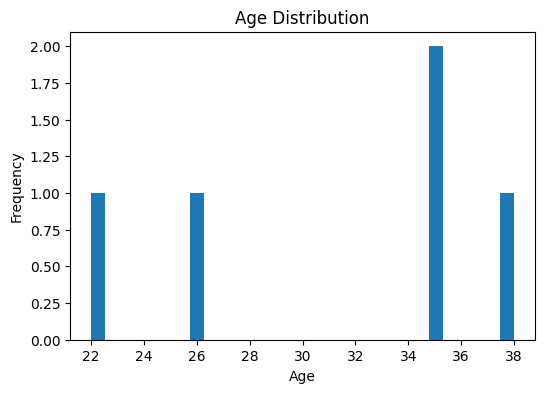

In [25]:

plt.figure(figsize=(6,4))
df['Age'].plot(kind='hist', bins=30)
plt.xlabel('Age'); plt.title('Age Distribution'); plt.show()


/var/folders/0q/b4wqh1gs5bvdwfddd5n47_wr0000gn/T/ipykernel_20779/2825958873.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=sorted(df['Pclass'].dropna().unique()))


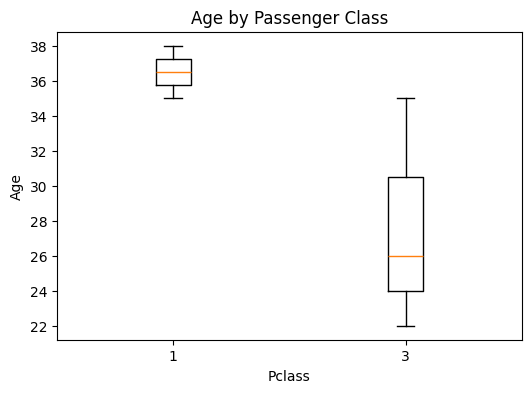

In [26]:

plt.figure(figsize=(6,4))
groups = [df.loc[df['Pclass']==c, 'Age'].dropna() for c in sorted(df['Pclass'].dropna().unique())]
plt.boxplot(groups, labels=sorted(df['Pclass'].dropna().unique()))
plt.xlabel('Pclass'); plt.ylabel('Age'); plt.title('Age by Passenger Class'); plt.show()


## Target & Features

In [27]:

cols = ['Age','Pclass','Sex','SibSp','Parch','Fare','Embarked']
data = df[cols].copy()
data['Alone'] = ((data['SibSp'].fillna(0) + data['Parch'].fillna(0)) == 0).astype(int)

y = data['Age']
X = data.drop(columns=['Age'])

num_features = ['Pclass','SibSp','Parch','Fare']
cat_features = ['Sex','Embarked','Alone']


## Preprocessing + Train/Test

In [28]:

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
categorical_transformer = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocess = ColumnTransformer([('num', numeric_transformer, num_features), ('cat', categorical_transformer, cat_features)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Train & Evaluate

In [29]:

model = Pipeline([('preprocess', preprocess), ('regressor', LinearRegression())])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)   # compatible across versions
rmse = float(np.sqrt(mse))                 # compute RMSE manually
r2 = r2_score(y_test, y_pred)

print({'MAE': round(mae,3), 'RMSE': round(rmse,3), 'R2': round(r2,3)})


{'MAE': 1.461, 'RMSE': 1.461, 'R2': nan}


/Users/subhasht/Desktop/VSCode Programs/GenAI_Curriculum/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


## Plots — Predicted vs Actual & Residuals

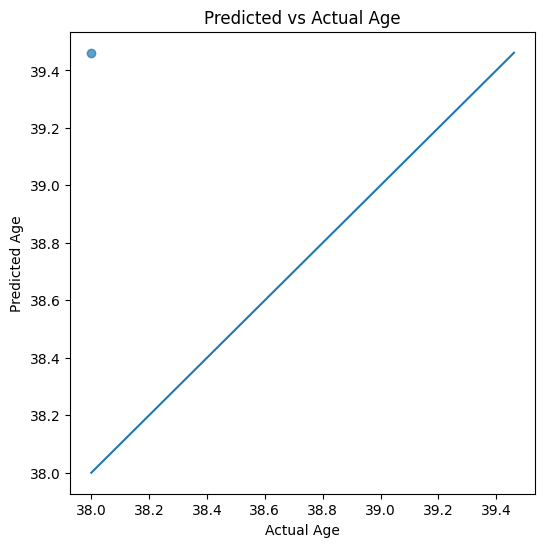

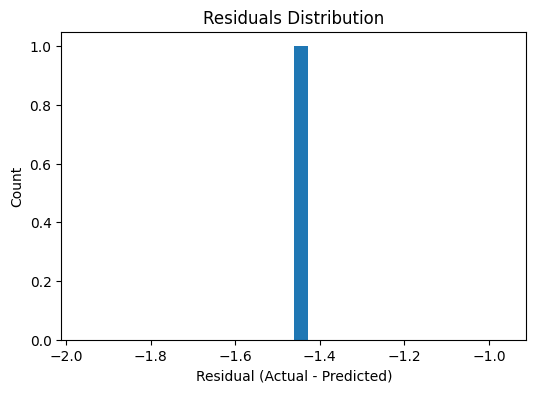

In [30]:

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
mn, mx = np.nanmin([y_test.min(), y_pred.min()]), np.nanmax([y_test.max(), y_pred.max()])
plt.plot([mn, mx], [mn, mx])
plt.xlabel('Actual Age'); plt.ylabel('Predicted Age'); plt.title('Predicted vs Actual Age'); plt.show()

residuals = y_test - y_pred
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30)
plt.xlabel('Residual (Actual - Predicted)'); plt.ylabel('Count'); plt.title('Residuals Distribution'); plt.show()


## Coefficients

In [31]:

ct = model.named_steps['preprocess']
ohe = ct.named_transformers_['cat'].named_steps['onehot']
num_names = num_features
cat_names = list(ohe.get_feature_names_out(cat_features))
all_feature_names = num_names + cat_names

coefs = model.named_steps['regressor'].coef_
coef_df = pd.DataFrame({'feature': all_feature_names, 'coef': coefs}).sort_values('coef', ascending=False)
coef_df.head(12)


,feature,coef
3,Fare,4.819664e+00
5,Sex_male,4.484665e+00
8,Alone_1,2.133952e+00
2,Parch,1.776357e-15
6,Embarked_S,0.000000e+00
7,Alone_0,-2.133952e+00
1,SibSp,-4.267904e+00
4,Sex_female,-4.484665e+00
0,Pclass,-4.641676e+00
